Gabriel ROCHON
Le notebook suivant se déroule en 6 parties

0) Organisation des données avec un one hot encoding

1) 1er algo de random forest à la main.
    Puis optimisation et test sur Kaggle

2) 2eme algo de random forest à la main.
    Puis optimisation et test sur Kaggle

3) Algo de random forest de sklearn.
    Puis optimisation et test sur Kaggle

4) Algo des k plus proches voisins.
    Puis optimisation et test sur Kaggle

5) Algo de la regression logistique.
    Puis optimisation et test sur Kaggle
    
6) Comparatif des algos et conclusion.

le temps d'execution totale est de 7 minutes
    


0)

In [305]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [306]:
current_directory = "c:/Users/gabriel/Desktop/Dauphine/Dauphine L2/Semestre 2/MIDO/Intro machine learning réseaux de neurones/lab5/lab5"
train_file_path = os.path.join(current_directory, 'titanic/train.csv')
test_file_path = os.path.join(current_directory, 'titanic/test.csv')
# j'accede aux csv train et test
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
print(df_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [307]:
features = ["Sex","Age","SibSp","Parch","Embarked_C","Embarked_Q","Embarked_S","Pclass_1","Pclass_2","Pclass_3"] # on met Pclass_1... car on effectue un one hot encoding
features = ["Sex","Age","SibSp","Parch","Embarked_C","Embarked_Q","Embarked_S","Pclass_1","Pclass_2","Pclass_3"]
y_train = df_train["Survived"]

Partie one hot encoding

In [308]:
# on fait un onehotencoding pour faciliter la mise en place de l'arbre
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
embarked_column_train  = df_train[["Embarked"]]
pclass_column_train  = df_train[["Pclass"]]
embarked_column_test = df_test[["Embarked"]]
pclass_column_test = df_test[["Pclass"]]
#ce sont les seuls qui peuvent être transformés en one hot encoding
embarked_encoded_train = encoder.fit_transform(embarked_column_train)
pclass_encoded_train = encoder.fit_transform(pclass_column_train)
embarked_encoded_test = encoder.fit_transform(embarked_column_test)
pclass_encoded_test = encoder.fit_transform(pclass_column_test)
#nous avons donc modifié embarked et pclass mais elles sont encore présentes dans les dataframes
df_train = df_train.drop(['Embarked', 'Pclass'], axis=1)
df_test = df_test.drop(['Embarked', 'Pclass'], axis=1)

df_train = pd.concat([df_train, embarked_encoded_train] , axis=1)
df_train = pd.concat([df_train, pclass_encoded_train] , axis=1)
df_test  = pd.concat([df_test, embarked_encoded_test] , axis=1)
df_test  = pd.concat([df_test, pclass_encoded_test] , axis=1)
X_test = pd.get_dummies(df_test[features]) # ceci nous servira pour tester notre modèle sur le kaggle
X_train = pd.get_dummies(df_train[features])

1)

Premier random forest à la main

In [327]:
#ici on entraine une random forest
def random_forest_a_la_main(n,X_train): # en effet on va l'entrainer sur le Xtrain 
    p=len(X_train)
    predictions=np.zeros(p)
    ensemble_arbre=[]
    for i in range(n): # le nombre d'arbre à fiter
        bag_train=X_train.sample(frac=0.6,replace=True) # cette fonction permet de prendre n valeur aléatoire nous en prenons 60% de X_train 
        y_bag_train=y_train.loc[bag_train.index] # ceci permet de prendre les valeurs de y_train qui correspondent à l'index de bag_train afin de pouvoir entrainer le modèle
        clf.fit(bag_train, y_bag_train) # on entraine le modèle
        ensemble_arbre.append(clf) # on ajoute l'arbre à notre ensemble
        predictions+=clf.predict(X_train) # on ajoute les prédictions de chaque arbre
        
    for j in range(len(predictions)):
        if predictions[j]/n<0.5: # si la moyenne des prédictions est inférieure à 0.5 alors on prédit 0 sinon 1 car les arbres auront predit 0 plus souvent
            predictions[j]=0
        else :
            predictions[j]=1 #ainsi à ce niveau predictions est la prediction de X_train
    valeur=0
    for i in range(len(predictions)):
        if predictions[i]==y_train[i]:
            valeur+=1 #enfin ici nous calculons la moyenne de bonnes reponses que nous à donner notre modèle
    #print(valeur/len(predictions)) #affiche la moyenne de bonnes réponses. On est dans les 82% de bonnes réponses
    return predictions,valeur/len(predictions),ensemble_arbre


Partie optimisation du 1er programme

In [328]:
start=time.time()
m=0
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
for j in range (6,25): #optimisons le nombre de feuilles pour maximiser la précision et pour minimiser l'overfitting et le temps on se limite à 25
    clf = DecisionTreeClassifier(max_leaf_nodes=j, random_state=88)
    pour_nombre_arbre=[]
    for i in range(20,55): # optimisons le nombre d'arbre à fiter pour maximiser la précision
        predictions,precision,ensemble_arbre=random_forest_a_la_main(i,X_train) # un appel à random_forest_a_la_main prend moins d'une seconde cependant beaucoup d'appel sont fait... 
        pour_nombre_arbre.append(precision) #ceci servira pour le graphique d'après
        if precision>m:
            m=precision
            best_predictions=predictions
            best_n=i
            best_deep=j
            vrai_graphique=pour_nombre_arbre
            vrai_ensemble_arbre=ensemble_arbre #represente l'ensemble des arbres qui ont été fitté
fin=time.time()
temps=fin-start
print('la precision est de ',m,'le temps est de ',temps, 'le nombre d arbre à fiter est de ',best_n, 'la profondeur des arbres a fiter est de ',best_deep) # on trouve donc que d'apres la random forest a la main une précision de 0.83 pour un nombre d'arbre entre 40 et 65 et un temps de 3 minutes


la precision est de  0.8294051627384961 le temps est de  183.5903558731079 le nombre d arbre à fiter est de  51 la profondeur des arbres a fiter est de  19


Nous n'optimons pas le fait que nous prenons 60% car plus menerait à de l'overfitting

Partie plot

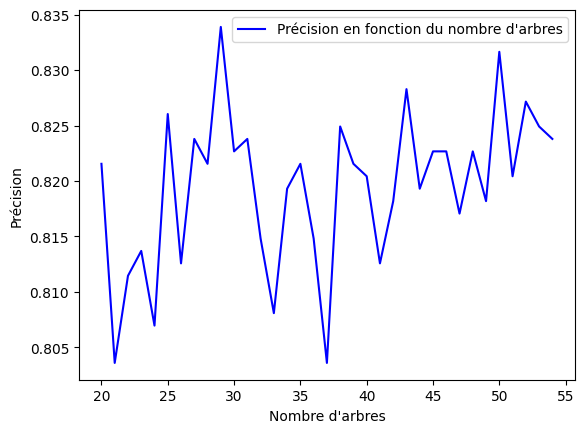

In [311]:

plt.plot(range(20,55),vrai_graphique,color="blue", label="Précision en fonction du nombre d'arbres") #voici un plot pour voir à quel point rajouter des arbres n'est pas rentable
plt.xlabel("Nombre d'arbres")
plt.ylabel("Précision")
plt.legend()
plt.show()
# grace à ce graphique j'ai pu voir qu'à partir de 55 arbres la précision ne changeait plus beaucoup ainsi je me suis limité à 55
#reste à faire (faire un oob, comparer avec le classique tps d'execution et capacité de prediction, le comparer à une autre méthode tenter deep learning le mettre sur kaggle+ rajouter photo graphique et commenter mieux code)

Partie kaggle 1 er programme et test de ma fonction

In [329]:
print(vrai_ensemble_arbre)
#vrai_ensemble_arbre correspond à l'ensemble des arbres entrainés par notre modèle
#on peut donc les utiliser pour faire des prédictions sur X_test
p=len(X_test)
predictions=np.zeros(p)
for clf in vrai_ensemble_arbre:
    predictions+=clf.predict(X_test)
for j in range(len(predictions)):
        if predictions[j]/(len(vrai_ensemble_arbre))<0.5: # si la moyenne des prédictions est inférieure à 0.5 alors on prédit 0 sinon 1 car les arbres auront predit 0 plus souvent
            predictions[j]=0
        else :
            predictions[j]=1 #ainsi à ce niveau predictions est la prediction de X_test
predictions = predictions.astype(int)
#print(predictions) # voici nos précisions sur x_test

passengerid = list(range(892, len(predictions)+892))

# Créons un DataFrame avec 'PassengerId' et 'Survived' comme colonne 
csv = pd.DataFrame({'PassengerId': passengerid, 'Survived': predictions})
print(len(csv))
csv.to_csv("C:/Users/gabriel/Desktop/Dauphine/Dauphine L2/Semestre 2/MIDO/Intro machine learning réseaux de neurones/lab5.csv",index=False) # on exporte nos prédictions sur x_test pour les soumettre sur kaggle
#j'ai une precision de 77% sur kaggle

[DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=19, random_state=88), DecisionTreeClassifier(max_leaf_nodes=1

Une precision de 77% sur kaggle

2)

Autre possibilité de random forest qui est mieux mais malheureusement très couteuse la principale différence est la cross validation qui prend beaucoup de temps

In [313]:
#autre possibilité 
#ici on entraine une random forest
def random_forest_a_la_main2(n,X_train): # en effet on va l'entrainer sur le Xtrain 
    p=len(X_train)
    test=0
    ensemble_arbre=[]
    for i in range(n): # le nombre d'arbre à fiter
        bag_train=X_train.sample(frac=0.6,replace=True) # cette fonction permet de prendre n valeur aléatoire nous en prenons sqrt(de la taille du tableau)
        y_bag_train=y_train.loc[bag_train.index] # ceci permet de prendre les valeurs de y_train qui correspondent à l'index de bag_train afin de pouvoir entrainer le modèle
        #print(np.mean(cross_val_score(clf, bag_train, y_bag_train, cv=6))) # affiche la performance moyenne de chaque arbre 
        clf.fit(bag_train, y_bag_train) # on entraine le modèle
        ensemble_arbre.append(clf) # on ajoute l'arbre à notre ensemble
        test+=np.mean(cross_val_score(clf, X_train, y_train, cv=5))
    return ensemble_arbre,test/n


Partie optimisation spoiler le programme suivant prend 3 min...

In [314]:
start=time.time()
m=0
for j in  [2, 4, 6, 8, 10]: #optimisons le nombre de feuilles pour maximiser la précision et pour minimiser l'overfitting et le temps on se limite à ce tableau
    clf = DecisionTreeClassifier(max_leaf_nodes=j, random_state=88)
    pour_nombre_arbre=[]
    for i in [1, 10, 100, 1000]: # optimisons le nombre d'arbre à fiter pour maximiser la précision
        ensemble_arbre_,precision=random_forest_a_la_main2(i,X_train) # un appel à random_forest_a_la_main prend moins d'une seconde cependant beaucoup d'appel sont fait... 
        pour_nombre_arbre.append(precision)
        if precision>m:
            m=precision
            best_n=i
            best_deep=j
            vrai_graphique=pour_nombre_arbre
            vrai_ensemble_arbre2=ensemble_arbre
fin=time.time()
temps=fin-start
print('la precision est de ',m,'le temps est de ',temps, 'le nombre d arbre à fiter est de ',best_n, 'la profondeur des arbres a fiter est de ',best_deep) # on trouve donc que d'apres la random forest a la main une précision de 0.83 pour un nombre d'arbre entre 40 et 65 et un temps de 3 minutes


la precision est de  0.801343292950851 le temps est de  166.1542191505432 le nombre d arbre à fiter est de  100 la profondeur des arbres a fiter est de  6


Le 100 et le 6 sont à retenir

Partie kaggle 2 ème programme

In [316]:
print(vrai_ensemble_arbre2)
#vrai_ensemble_arbre correspond à l'ensemble des arbres entrainés par notre modèle
#on peut donc les utiliser pour faire des prédictions sur X_test
p=len(X_test)
predictions=np.zeros(p)
for clf in vrai_ensemble_arbre2:
    predictions+=clf.predict(X_test)
for j in range(len(predictions)):
        if predictions[j]/(len(vrai_ensemble_arbre2))<0.5: # si la moyenne des prédictions est inférieure à 0.5 alors on prédit 0 sinon 1 car les arbres auront predit 0 plus souvent
            predictions[j]=0
        else :
            predictions[j]=1 #ainsi à ce niveau predictions est la prediction de X_test
predictions = predictions.astype(int)
#print(predictions) # voici nos précisions sur x_test

passengerid = list(range(892, len(predictions)+892))

# Créons un DataFrame avec 'PassengerId' et 'Survived' comme colonne 
csv = pd.DataFrame({'PassengerId': passengerid, 'Survived': predictions})
print(len(csv))
csv.to_csv("C:/Users/gabriel/Desktop/Dauphine/Dauphine L2/Semestre 2/MIDO/Intro machine learning réseaux de neurones/prog2.csv",index=False) # on exporte nos prédictions sur x_test pour les soumettre sur kaggle



[DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=24, random_state=88), DecisionTreeClassifier(max_leaf_nodes=2

Precision de 75.5 sur kaggle

Partie random forest classique pour comparer

In [330]:
from sklearn.ensemble import RandomForestClassifier
start=time.time()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)
print('la precision est de ',np.mean(cross_val_score(model, X_train, y_train, cv=5)))
y_pred = model.predict(X_test) # a tester sur kaggle
end=time.time()
print('le temps est de ',end-start)


la precision est de  0.817079907099366
le temps est de  1.8697350025177002


On peut voir que c'est plus rapide en effet il n'y a pas d'optimisation

Partie random forest avec optimisation 

In [332]:
from sklearn.model_selection import GridSearchCV
star=time.time()
parameters = {'n_estimators':[1, 10, 100, 1000], 'max_depth':[2, 4, 6, 8, 10]} # on se limite à ceci question de temps d'execution
clf = GridSearchCV(RandomForestClassifier(), parameters, verbose=True)
clf.fit(X_train, y_train)
clf.best_params_
clf.best_score_
end=time.time()
print('le temps est de ',end-star)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
le temps est de  80.89305686950684
{'max_depth': 6, 'n_estimators': 100}
0.813709120582512


On peut donc voir que la prediction est plus précise que mon deuxième algorithme. 0.81 vs 0.80 mais inférieur à mon premier 0.83 (peut etre du à un lèger overfitting de ma part car pas de grid search) 
Deuxième point on peut voir une différence de temps énorme entre mes programmes et celui ci (3 minutes et 3 minutes contre à peu pres une minute)
On peut aussi voir que mon deuxième programme trouve exactement les mêmes paramètres

Partie Kaggle sur randomforest de sklearn

In [319]:
predictions=clf.predict(X_test)
predictions = predictions.astype(int)
passengerid = list(range(892, len(predictions)+892))
csv = pd.DataFrame({'PassengerId': passengerid, 'Survived': predictions})
print(len(csv))
csv.to_csv("C:/Users/gabriel/Desktop/Dauphine/Dauphine L2/Semestre 2/MIDO/Intro machine learning réseaux de neurones/progsklearn.csv",index=False) # on exporte nos prédictions sur x_test pour les soumettre sur kaggle



418


La precision de 77.5%. La meilleure que j'ai trouvé

4)

Partie k plus proche voisins et optimisation

In [326]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
start=time.time()
nn = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier())
parameters = {'kneighborsclassifier__n_neighbors':range(1, 100)}
clf = GridSearchCV(nn, parameters, verbose=1)
X_train=X_train.fillna(0) #sinon il y a des problèmes de nan
clf.fit(X_train, y_train)
x=clf.best_params_
print(x)
z=clf.best_score_
print(z)
end=time.time()
print('le temps est de ',end-start)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'kneighborsclassifier__n_neighbors': 18}
0.8036218693114054
le temps est de  24.948251724243164


Partie kaggle

In [322]:
X_test=X_test.fillna(0)
predictions=clf.predict(X_test)
predictions = predictions.astype(int)
passengerid = list(range(892, len(predictions)+892))
csv = pd.DataFrame({'PassengerId': passengerid, 'Survived': predictions})
print(len(csv))
csv.to_csv("C:/Users/gabriel/Desktop/Dauphine/Dauphine L2/Semestre 2/MIDO/Intro machine learning réseaux de neurones/progskvoisin.csv",index=False) # on exporte nos prédictions sur x_test pour les soumettre sur kaggle

418


La precision est de 76.3 sur kaggle

5)

Partie regression logistic

In [325]:
from sklearn.linear_model import LogisticRegression
import numpy as np
start=time.time()
nn = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())
parameters = {'logisticregression__C':np.linspace(0, 100, 1000)}
clf = GridSearchCV(nn, parameters, verbose=1)
X_train=X_train.fillna(0) #sinon il y a des problèmes de nan
clf.fit(X_train, y_train)
end=time.time()
x=clf.best_params_
print(x)
z=clf.best_score_
print(z)
temps=end-start
print("le temps est de ",temps)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
{'logisticregression__C': 0.1001001001001001}
0.7788776599083548
le temps est de  74.53577899932861


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
5 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gabrie

Kaggle logistic

In [324]:
X_test=X_test.fillna(0)
predictions=clf.predict(X_test)
predictions = predictions.astype(int)
passengerid = list(range(892, len(predictions)+892))
csv = pd.DataFrame({'PassengerId': passengerid, 'Survived': predictions})
print(len(csv))
csv.to_csv("C:/Users/gabriel/Desktop/Dauphine/Dauphine L2/Semestre 2/MIDO/Intro machine learning réseaux de neurones/progslogistic.csv",index=False) # on exporte nos prédictions sur x_test pour les soumettre sur kaggle

418


La précision est de 77% sur kaggle

6 Compararaison et conclusion

Le random forest directement implanté dans python est clairement meilleur que mon programme car elle est plus rapide plus constante plus rapide... 
Cependant mon programme marche relativement mieux que l'algo k plus proches voisins k compris entre 1 et 100 pour ce type de donnée.
Cependant mon programme manque de stabilité il donne des résultats qui fluctuent légerement à chaque fois...
voici l'ordre des meilleurs algo sur kaggle : randomforets > regression logistic > mon programme1 > k plus proche voisin > mon programme2